In [1]:
!pip install ultralytics -q
print("YOLO installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00
YOLO installed


In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted")

Mounted at /content/drive
Google Drive mounted


In [3]:
import os

DRIVE_BASE = '/content/drive/MyDrive/Obj_detection_segmentation'
VIDEO_NAME = 'traffic.mp4'
OUTPUT_NAME = 'traffic_detection_output.mp4'

VIDEO_PATH  = os.path.join(DRIVE_BASE, VIDEO_NAME)
OUTPUT_PATH = os.path.join(DRIVE_BASE, OUTPUT_NAME)
LOCAL_RAW   = '/content/traffic_raw.mp4'
LOCAL_H264  = '/content/traffic_h264.mp4'

assert os.path.exists(VIDEO_PATH), (
    f'ERROR: Video not fount at: {VIDEO_PATH}\n'
    f'Check spelling or path to video'
)

size_mb = os.path.getsize(VIDEO_PATH) / 1e6
print(f'Video found: {VIDEO_PATH} ({size_mb:.1f} MB)')
print(f'Output will be saved to {OUTPUT_PATH}')

Video found: /content/drive/MyDrive/Obj_detection_segmentation/traffic.mp4 (7.0 MB)
Output will be saved to /content/drive/MyDrive/Obj_detection_segmentation/traffic_detection_output.mp4


In [4]:
import cv2
import numpy as np
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

# COCO class IDs
CAR_ID = 2
BUS_ID = 5
TARGET_IDS = [CAR_ID, BUS_ID]

print(f'Model Loaded: {model}')
print(f'car class -> {CAR_ID}| bus class -> {BUS_ID}')

# Color classifier
YELLOW_LOWER = np.array([18, 80, 80], dtype=np.uint8)
YELLOW_UPPER = np.array([35, 255, 255], dtype=np.uint8)

RED_LOWER1   = np.array([0,   80, 80],  dtype=np.uint8)   # 0–10°
RED_UPPER1   = np.array([10, 255, 255], dtype=np.uint8)
RED_LOWER2   = np.array([160, 80, 80],  dtype=np.uint8)   # 160–180°
RED_UPPER2   = np.array([180,255, 255], dtype=np.uint8)

# BLACK_LOWER  = np.array([0,   0,   0],  dtype=np.uint8)
# BLACK_UPPER  = np.array([180, 255, 50], dtype=np.uint8)   # low Value = dark/black

# Minimum % of bbox pixels that must match a colour to be classified
# COLOR_PIXEL_THRESHOLD = 0.08   # 8%
COLOR_PIXEL_THRESHOLD = 0.15   # 15%

def classify_car_color(frame, x1, y1, x2, y2):
  margin_x = max(int((x2-x1) * 0.12), 4)
  margin_y = max(int((y2-y1) * 0.12), 4)
  crop = frame[y1 + margin_y : y2 - margin_y,
               x1 + margin_x : x2 - margin_x]

  if crop.size == 0:
    return None

  hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
  total = hsv.shape[0] * hsv.shape[1]

  yellow_px = cv2.countNonZero(cv2.inRange(hsv, YELLOW_LOWER, YELLOW_UPPER))
  red_px = cv2.countNonZero(cv2.inRange(hsv, RED_LOWER1, RED_UPPER1) | cv2.inRange(hsv, RED_LOWER2, RED_UPPER2))
  # black_px = cv2.countNonZero(cv2.inRange(hsv, BLACK_LOWER, BLACK_UPPER))

  y_ratio = yellow_px / total
  r_ratio = red_px / total
  # b_ratio  = black_px / total

  # Determine dominant colour
  # ratios = {'yellow': y_ratio, 'red': r_ratio, 'black': b_ratio}
  ratios = {'yellow': y_ratio, 'red': r_ratio}
  best   = max(ratios, key=ratios.get)

  if ratios[best] > COLOR_PIXEL_THRESHOLD:
      return best
  return None

print('Color classifier loaded')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model Loaded: YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

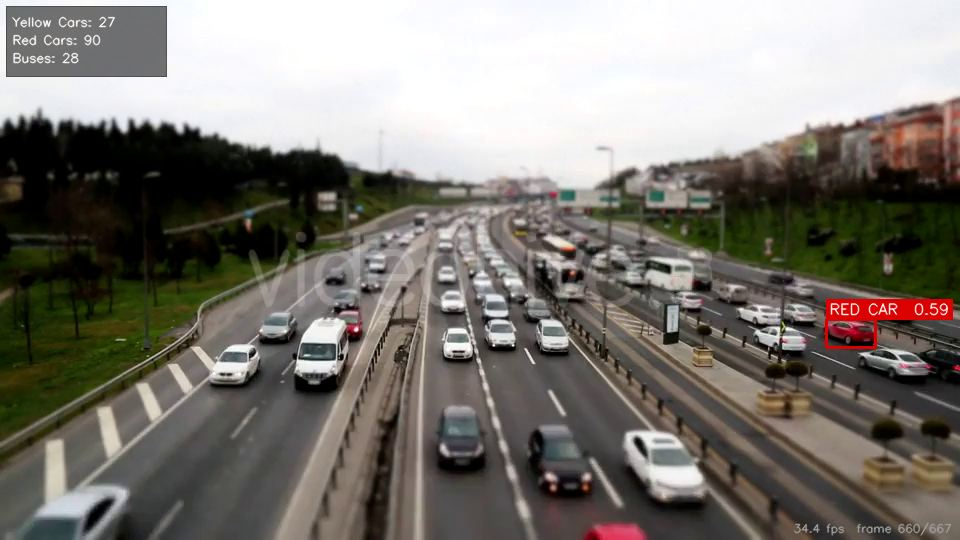

Frame  660/667 | Yellow: 27 | Red: 90 | Bus: 28 | 34.4 fps

Detection complete!
 Frames processed : 667
   Total yellow cars : 27
   Total red cars    : 91
   Total buses       : 28
 Total time       : 19.3s  (34.4 fps avg)


In [5]:
from IPython.display import display, Image as IPImage, clear_output
import time

CONF_THRESHOLD  = 0.35
DISPLAY_EVERY_N = 15     # preview every N frames

# Bounding-box colours (BGR)
COLOR_MAP = {
    'yellow_car': (0,   220, 255),   # vivid yellow
    'red_car'   : (0,   0,   220),   # red
    # 'black_car' : (180, 180, 180),   # light grey box (visible on dark car)
    'bus'       : (200, 60,  255),   # purple
}
TEXT_COLOR = (255, 255, 255)
FONT = cv2.FONT_HERSHEY_SIMPLEX

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened()

W     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS   = cap.get(cv2.CAP_PROP_FPS) or 25.0
TOTAL = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(LOCAL_RAW, fourcc, FPS, (W, H))

print(f'{W}×{H} @ {FPS:.1f} fps | {TOTAL} frames')
print('Detecting yellow cars, red cars, buses...\n')

frame_idx   = 0
# peak = {'yellow_car': 0, 'red_car': 0, 'black_car': 0, 'bus': 0}
totals = {'yellow_car': 0, 'red_car': 0, 'bus': 0}
seen_ids = set()   # stores track IDs we've already counted
t0 = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # YOLOv8 inference
    """
    results = model(
        frame,
        conf=CONF_THRESHOLD,
        classes=TARGET_IDS,
        tracker='bytetrack.yaml',
        verbose=False
    )[0]"""
    results = model.track(
        frame,
        conf=CONF_THRESHOLD,
        classes=TARGET_IDS,
        tracker='bytetrack.yaml',
        persist=True,
        verbose=False
    )[0]

    # counts = {'yellow_car': 0, 'red_car': 0, 'black_car': 0, 'bus': 0}
    # counts = {'yellow_car': 0, 'red_car': 0, 'bus': 0}
    # totals = {'yellow_car': 0, 'red_car': 0, 'black_car': 0, 'bus': 0}
    # seen_ids = set()

    for box in results.boxes:
        cls_id          = int(box.cls[0])
        conf            = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        if cls_id == BUS_ID:
            category = 'bus'
            label    = f'BUS  {conf:.2f}'
        else:   # car — classify colour
            color = classify_car_color(frame, x1, y1, x2, y2)
            if color == 'yellow':
                category = 'yellow_car'
                label    = f'YELLOW CAR  {conf:.2f}'
            elif color == 'red':
                category = 'red_car'
                label    = f'RED CAR  {conf:.2f}'
            #elif color == 'black':
            #    category = 'black_car'
            #    label    = f'BLACK CAR  {conf:.2f}'
            else:
                continue   # ← skip drawing entirely for unclassified cars

        # totals[category] += 1
        if results.boxes.id is not None and box.id is not None:
            track_id   = int(box.id[0])
            unique_key = f'{category}_{track_id}'
            if unique_key not in seen_ids:
                seen_ids.add(unique_key)
                totals[category] += 1

        # if category in seen_ids:
        #    continue
        # seen_ids.add(category
        # if category in counts:
        #    counts[category] += 1
        # if category in totals:
        #    totals[category] += 1

        box_col = COLOR_MAP[category]

        # Bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), box_col, 2)

        # Label badge
        (tw, th), _ = cv2.getTextSize(label, FONT, 0.50, 1)
        cv2.rectangle(frame, (x1, y1 - th - 8), (x1 + tw + 6, y1), box_col, -1)
        cv2.putText(frame, label, (x1 + 3, y1 - 5),
                    FONT, 0.50, TEXT_COLOR, 1, cv2.LINE_AA)

    # Update peak counts
    # for k in peak:
    #    peak[k] = max(peak[k], counts[k])

    elapsed      = max(time.time() - t0, 1e-6)
    fps_live     = frame_idx / elapsed
    progress_pct = frame_idx / TOTAL * 100 if TOTAL else 0

    """
    # Count banner across the TOP of the frame
    banner_h = 52
    banner   = frame.copy()
    cv2.rectangle(banner, (0, 0), (W, banner_h), (20, 20, 20), -1)
    cv2.addWeighted(banner, 0.65, frame, 0.35, 0, frame)

    # Three count blocks evenly spaced
    blocks = [
        (f'YELLOW CAR', counts['yellow_car'], peak['yellow_car'], COLOR_MAP['yellow_car'], W * 1 // 8),
        (f'RED CAR',    counts['red_car'],    peak['red_car'],    COLOR_MAP['red_car'],    W * 3 // 8),
        # (f'BLACK CAR',  counts['black_car'],  peak['black_car'],  COLOR_MAP['black_car'],  W * 5 // 8),
        (f'BUS',        counts['bus'],         peak['bus'],        COLOR_MAP['bus'],        W * 7 // 8),
    ]

    for title, cnt, pk, col, cx in blocks:
        # Count number (large)
        count_str = str(cnt)
        (cw, ch), _ = cv2.getTextSize(count_str, FONT, 1.2, 2)
        cv2.putText(frame, count_str, (cx - cw // 2, 38),
                    FONT, 1.2, col, 2, cv2.LINE_AA)
        # Label (small, above the number)
        (lw, lh), _ = cv2.getTextSize(title, FONT, 0.42, 1)
        cv2.putText(frame, title, (cx - lw // 2, 14),
                    FONT, 0.42, col, 1, cv2.LINE_AA)
        # Peak (tiny, below number)
        pk_str = f'peak {pk}'
        (pw, ph), _ = cv2.getTextSize(pk_str, FONT, 0.36, 1)
        cv2.putText(frame, pk_str, (cx - pw // 2, 50),
                    FONT, 0.36, (180, 180, 180), 1, cv2.LINE_AA)

    # Dividers between blocks
    # cv2.line(frame, (W // 4, 2), (W // 4, banner_h - 2), (60, 60, 60), 1)
    # cv2.line(frame, (W // 2, 2), (W // 2, banner_h - 2), (60, 60, 60), 1)
    # cv2.line(frame, (W * 3 // 4, 2), (W * 3 // 4, banner_h - 2), (60, 60, 60), 1)
    cv2.line(frame, (W // 3, 2), (W // 3, banner_h - 2), (60, 60, 60), 1)
    cv2.line(frame, (W * 2 // 3, 2), (W * 2 // 3, banner_h - 2), (60, 60, 60), 1)

    # Progress bar at bottom of banner
    bar_w = int(W * progress_pct / 100)
    cv2.rectangle(frame, (0, banner_h - 3), (bar_w, banner_h), (0, 200, 120), -1)
    """

    # compact top-left panel, running totals only
    panel_lines = [
        ('Yellow Cars', totals['yellow_car'], (255, 255, 255)),
        ('Red Cars', totals['red_car'], (255, 255, 255)),
        ('Buses', totals['bus'], (255, 255, 255)),
    ]

    pad     = 8
    lh      = 18          # line height in pixels
    panel_w = 160
    panel_h = pad * 2 + lh * len(panel_lines)

    overlay = frame.copy()
    cv2.rectangle(overlay, (6, 6), (6 + panel_w, 6 + panel_h), (20, 20, 20), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)
    cv2.rectangle(frame, (6, 6), (6 + panel_w, 6 + panel_h), (80, 80, 80), 1)

    for i, (label, total, col) in enumerate(panel_lines):
        y = 6 + pad + i * lh + 12
        txt = f'{label}: {total}'
        cv2.putText(frame, txt, (12, y), FONT, 0.42, col, 1, cv2.LINE_AA)

    # Speed tag bottom-right
    speed_txt = f'{fps_live:.1f} fps  frame {frame_idx}/{TOTAL}'
    (sw, sh), _ = cv2.getTextSize(speed_txt, FONT, 0.38, 1)
    cv2.putText(frame, speed_txt, (W - sw - 8, H - 8),
                FONT, 0.38, (160, 160, 160), 1, cv2.LINE_AA)

    writer.write(frame)

    # Notebook preview
    if frame_idx % DISPLAY_EVERY_N == 0:
        clear_output(wait=True)
        _, buf = cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, 78])
        display(IPImage(data=buf.tobytes()))
        print(f'Frame {frame_idx:>4}/{TOTAL} | '
              f'Yellow: {totals["yellow_car"]} | '
              f'Red: {totals["red_car"]} | '
              f'Bus: {totals["bus"]} | '
              f'{fps_live:.1f} fps')

    frame_idx += 1

cap.release()
writer.release()

print(f'\nDetection complete!')
print(f' Frames processed : {frame_idx}')
print(f'   Total yellow cars : {totals["yellow_car"]}')
print(f'   Total red cars    : {totals["red_car"]}')
print(f'   Total buses       : {totals["bus"]}')
print(f' Total time       : {elapsed:.1f}s  ({fps_live:.1f} fps avg)')


In [6]:
# Re-encode to H.264 & save back to Google Drive

import shutil

print('Re-encoding to H.264...')
!ffmpeg -y -i {LOCAL_RAW} \
        -vcodec libx264 -crf 22 -preset fast \
        -movflags +faststart \
        {LOCAL_H264} -loglevel error

shutil.copy2(LOCAL_H264, OUTPUT_PATH)

out_mb = os.path.getsize(OUTPUT_PATH) / 1e6
print(f'Saved to Google Drive!')
print(f'MyDrive/Obj_detection_segmentation/{OUTPUT_NAME}  ({out_mb:.1f} MB)')

Re-encoding to H.264...
Saved to Google Drive!
MyDrive/Obj_detection_segmentation/traffic_detection_output.mp4  (6.4 MB)


In [7]:
# Play output video inline

from IPython.display import HTML
from base64 import b64encode

with open(LOCAL_H264, 'rb') as f:
    b64 = b64encode(f.read()).decode()

HTML(f'''
<h3 style="font-family:sans-serif;color:#ddd">🚗🚌 Traffic Detection — Output Preview</h3>
<video width="960" controls autoplay loop
       style="border:2px solid #555;border-radius:8px;max-width:100%;background:#000">
  <source src="data:video/mp4;base64,{b64}" type="video/mp4">
</video>
<p style="font-family:sans-serif;color:#888;font-size:13px">
  Saved → <code>MyDrive/Obj_detection_segmentation/traffic_detected_output.mp4</code>
</p>
''')